In [38]:
#music21 enables us to interact with note and chord objects from our song data
from music21 import converter, instrument, note, chord
import glob
import pandas as pd
import numpy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, LSTM, Dense, Activation
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt 
from music21 import stream

57/57 [==============================] - 51s 659ms/step - loss: 3.5655


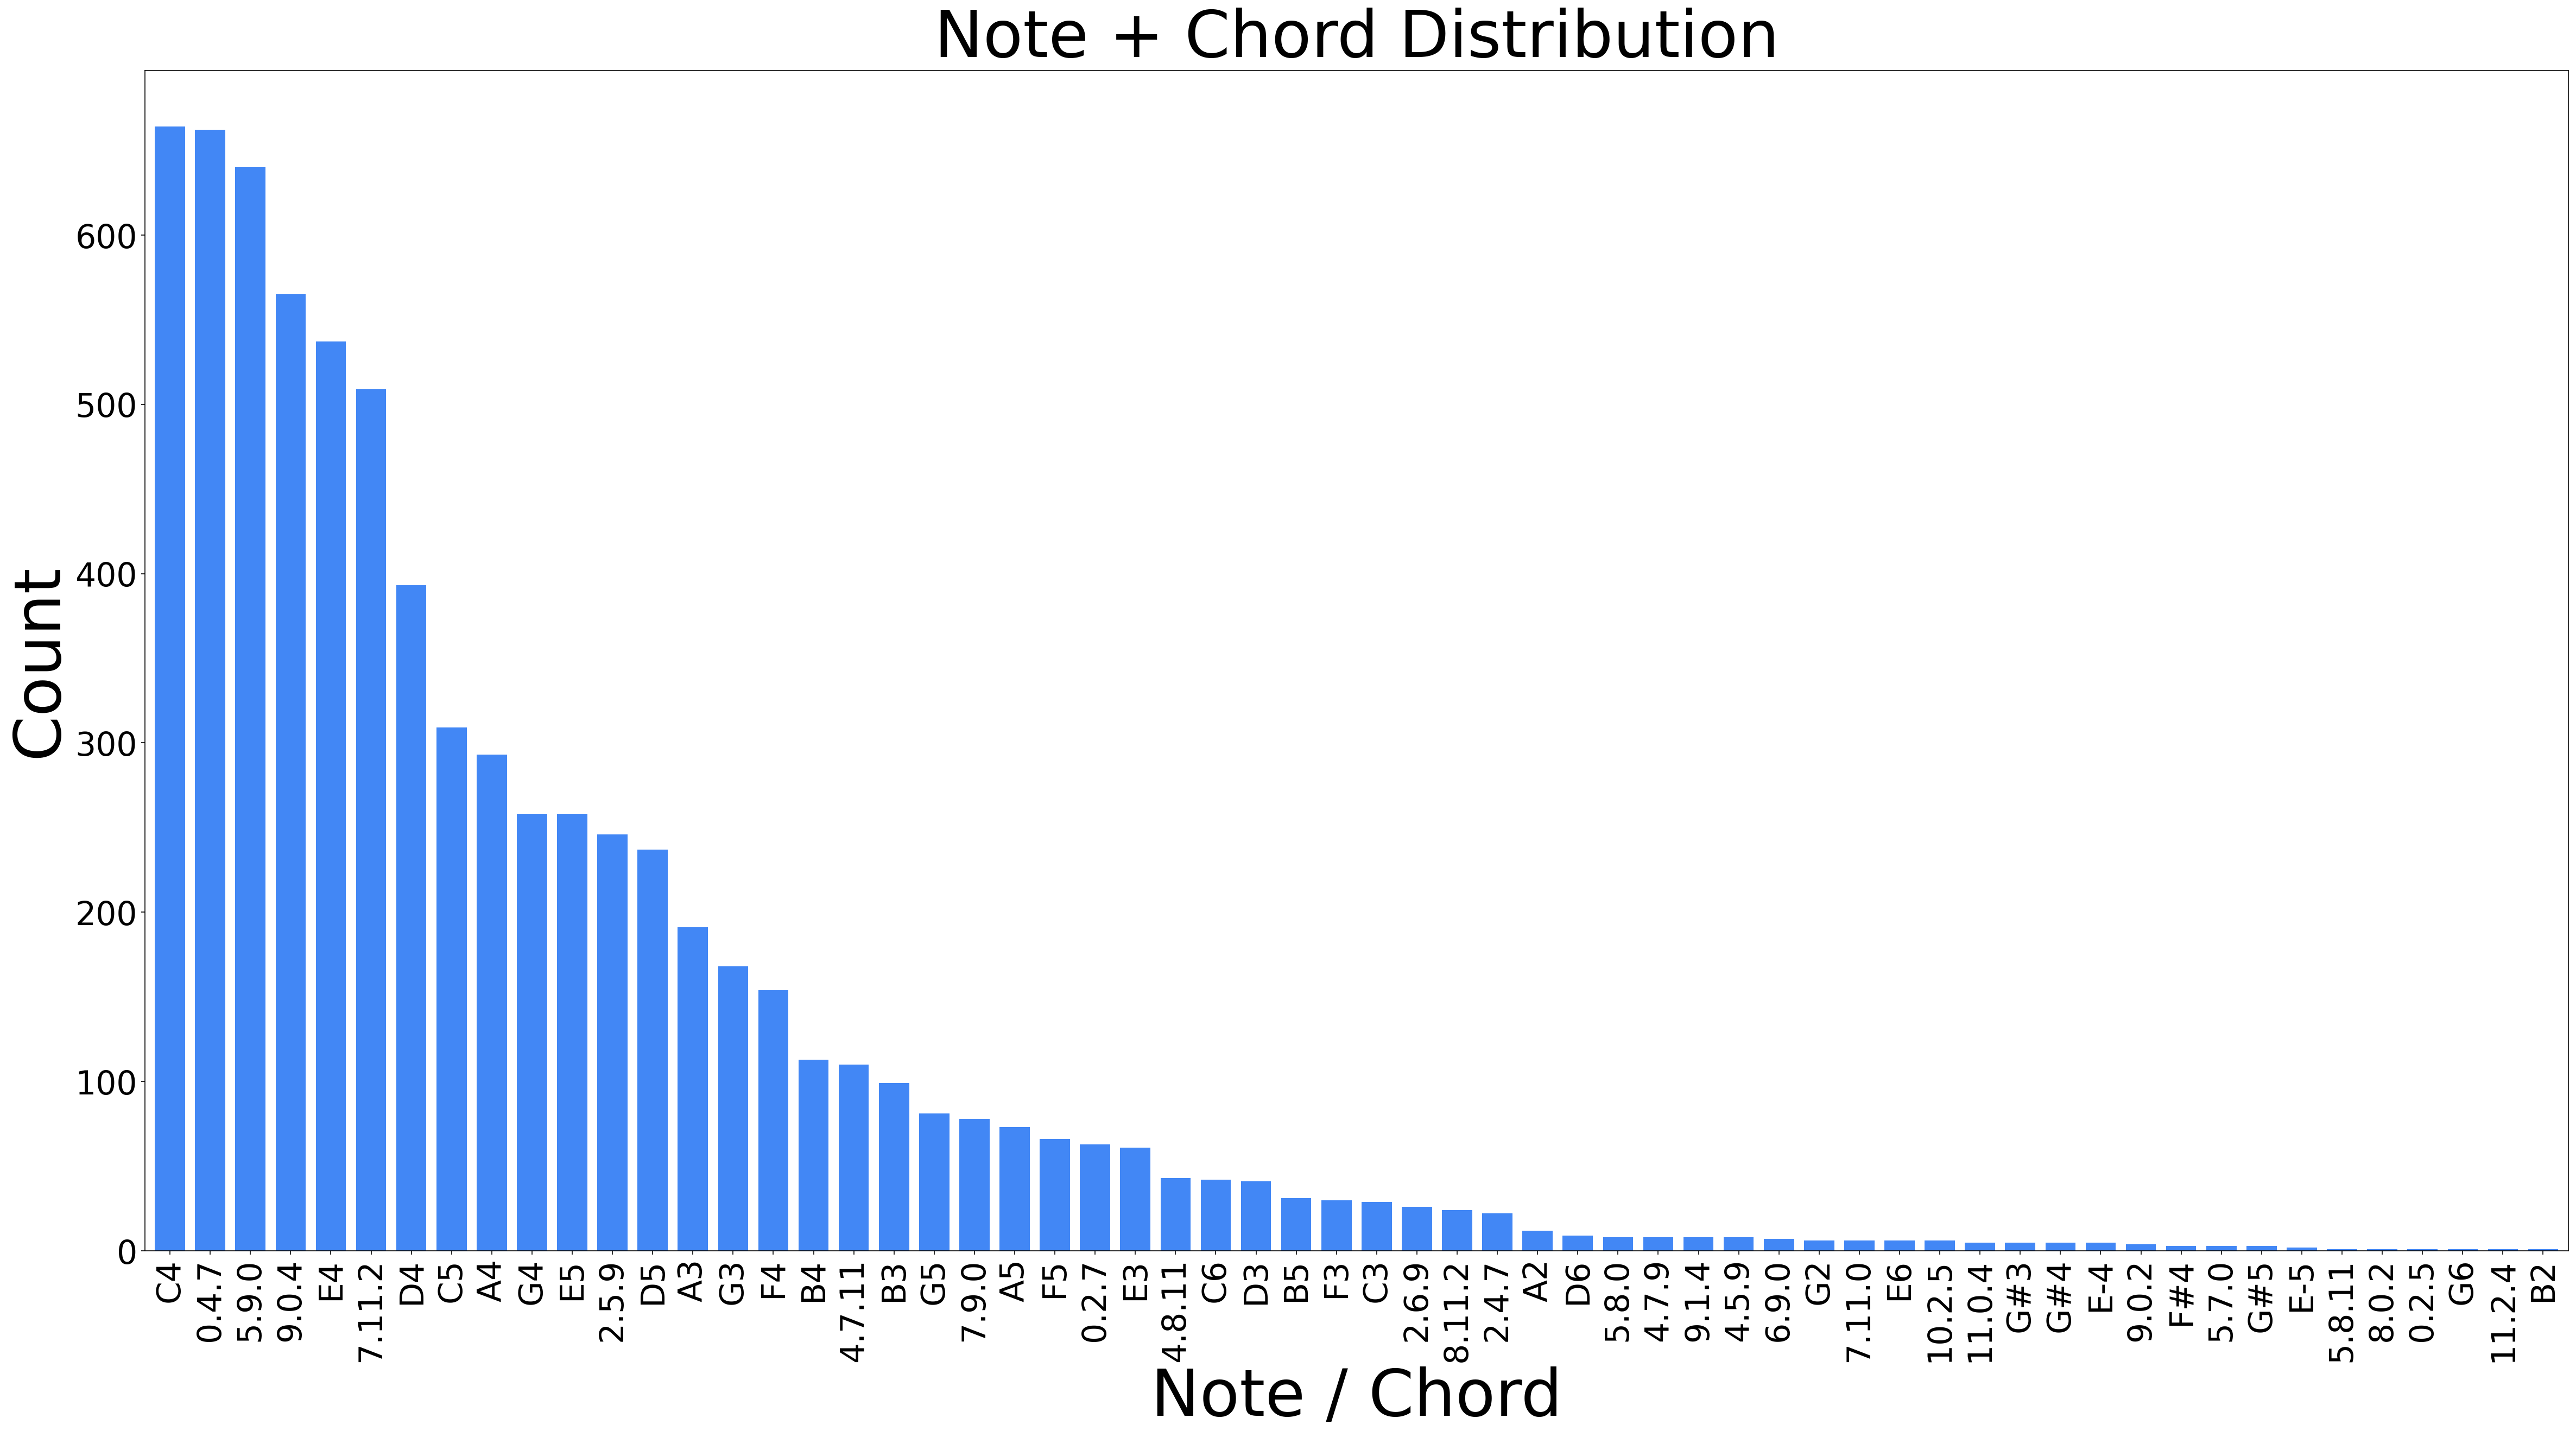

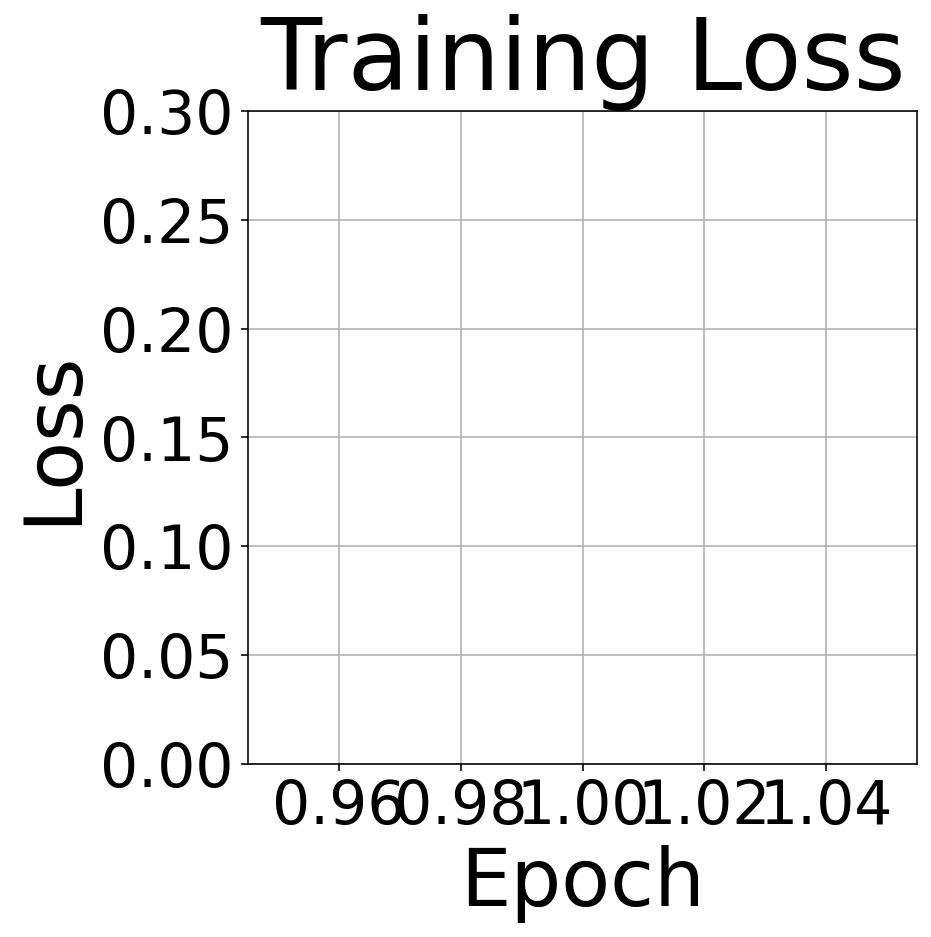

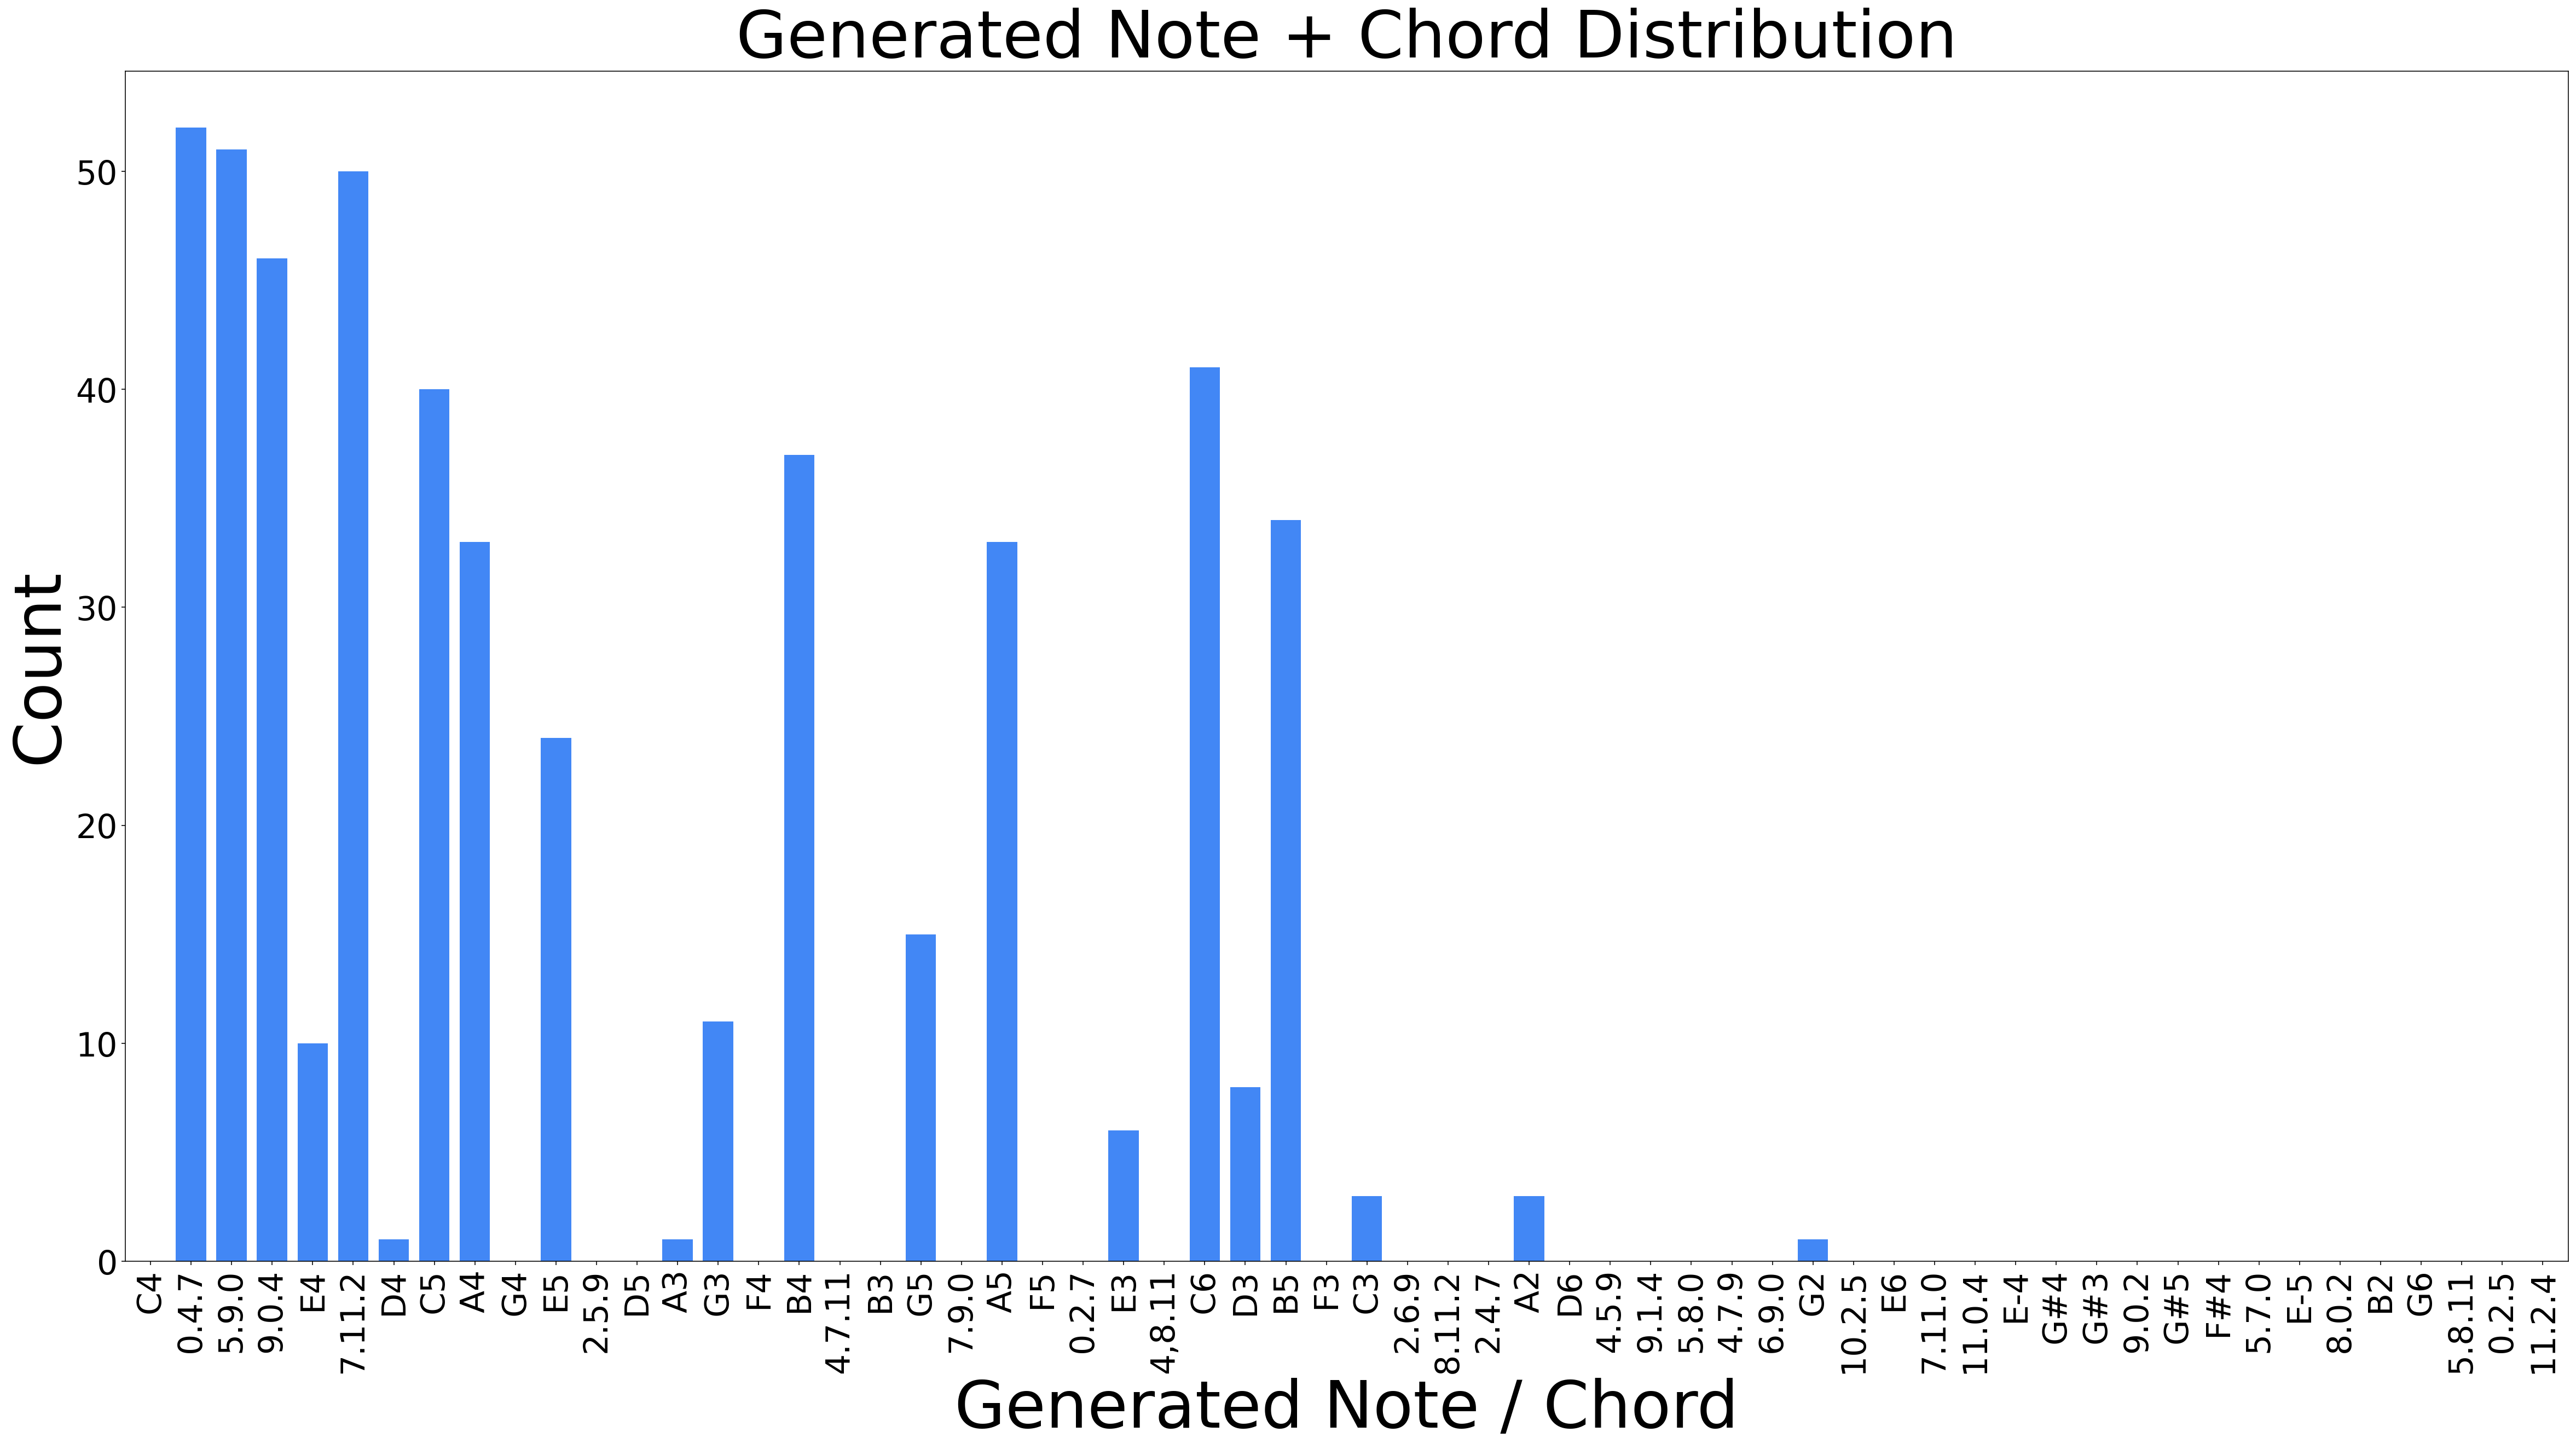

In [53]:
notes = import_midi_files("lighthouse_bootcamp/final_project/tensorflow-music-generator/extra_songs/*.midi")
plot_data_histogram(notes)
network_input, network_output, n_vocab = encode_data(notes)
model = build_model(network_input, n_vocab)
model = train_model("weights-improvement--pop_test-{epoch:02d}-{loss:.4f}-bigger.hdf5",model,network_input,network_output,epochs=1)
plot_training_loss(model)
output_notes = generate_notes(model, notes, network_input, n_vocab)
plot_output_histogram(output_notes)
create_midi_file(output_notes,path='final_output.mid')

In [39]:
def import_midi_files(path):
    #import midi tracks and break them down into music21 variables. Then extract the note/chord and add it to notes
    
    notes = []
    for file in glob.glob(path):
        midi = converter.parse(file)
        notes_to_parse = None
        parts = instrument.partitionByInstrument(midi)
        if parts: # file has instrument parts
            notes_to_parse = parts.parts[0].recurse()
        else: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes
        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))
    return notes

In [50]:
def plot_data_histogram(notes):
    #plot note and chord distribution of all our notes+chords in our song data

    ser = pd.Series(notes)
    ser.value_counts().plot.bar(figsize=[40,20],color='#4287f5',xlabel='Note/Chord',fontsize=30, width=.75)
    plt.title("Note + Chord Distribution",fontsize=60)
    plt.xlabel("Note / Chord",fontsize=60)
    plt.ylabel("Count",fontsize=60)

In [42]:
def encode_data(notes):
    #encode data to numerical representation
    
    #adjust sequence length to effect training duration or training loss
    sequence_length = 25
    # get all pitch names
    pitchnames = sorted(set(item for item in notes))
    # create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
    network_input = []
    network_output = []
    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])
    n_patterns = len(network_input)
    # reshape the input into a format compatible with LSTM layers
    network_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    n_vocab = len(set(notes))
    return network_input / float(n_vocab), to_categorical(network_output), n_vocab

In [43]:
def build_model(network_input,n_vocab):
    #LSTM RNN used 
    
    model = Sequential()
    model.add(LSTM(
            256,
            input_shape=(network_input.shape[1], network_input.shape[2]),
            return_sequences=True
        ))
    model.add(Dropout(0.3))
    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(256))
    model.add(Dense(256))
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    return model

In [44]:
def train_model(path,model,network_input,network_output,epochs): 
    #fit model to input and output data, and save model checkpoints to provided path. 
    #can later import these checkpoint weights to rebuild a previous model.
    #My best results were 500 epochs+ with val loss of ~.03
    
    filepath = path    
    checkpoint = ModelCheckpoint(
        filepath, monitor='loss', 
        verbose=0,        
        save_best_only=True,        
        mode='min'
    )    
    callbacks_list = [checkpoint]
    model = model.fit(network_input, network_output, epochs=epochs, batch_size=128, callbacks=callbacks_list)
    
    return model

In [45]:
def plot_training_loss(model): 
    #plot how the model trained
    
    training_loss = model.history['loss']
    epoch_count = range(1, len(training_loss) + 1)

    plt.figure(figsize=[6,6])
    plt.plot(epoch_count, training_loss)
    plt.xlabel('Epoch', fontsize=40)
    plt.ylabel('Loss', fontsize=40)
    plt.title('Training Loss', fontsize = 50)
    plt.ylim(0,.3)
    plt.grid(True)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.show()

In [52]:
def generate_notes(model,notes,network_input,n_vocab):
    #generate random starting note then predict the next 500 notes to create a song
    
    start = numpy.random.randint(0, len(network_input)-1)
    pitchnames = sorted(set(item for item in notes))
    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
    pattern = network_input[start]
    prediction_output = []
    
    # generate 500 notes
    for note_index in range(500):
        prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)
        prediction = model.model.predict(prediction_input, verbose=0)
        index = numpy.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)
        pattern = numpy.append(pattern,index)
        pattern = pattern[1:len(pattern)]
    
    offset = 0
    output_notes = []
    
    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)
        # increase offset each iteration so that notes do not stack
        offset += 0.5
        
    return output_notes

In [47]:
def plot_output_histogram(output_notes):  
    #manual index and value entry
    idx = ['C4','0.4.7','5.9.0','9.0.4','E4','7.11.2','D4','C5','A4','G4','E5','2.5.9','D5','A3','G3','F4','B4','4.7.11','B3','G5','7.9.0','A5','F5','0.2.7','E3','4,8.11','C6','D3','B5','F3','C3','2.6.9','8.11.2','2.4.7','A2','D6','4.5.9','9.1.4','5.8.0','4.7.9','6.9.0','G2','10.2.5','E6','7.11.0','11.0.4','E-4','G#4','G#3','9.0.2','G#5','F#4','5.7.0','E-5','8.0.2','B2','G6','5.8.11','0.2.5','11.2.4']
    values = [0,52,51,46,10,50,1,40,33,0,24,0,0,1,11,0,37,0,0,15,0,33,0,0,6,0,41,8,34,0,3,0,0,0,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,]
    ser3 = pd.Series(values, index = idx)

    ser3.plot.bar(figsize=[40,20],color='#4287f5',xlabel='Note/Chord',fontsize=30, width=.75)
    plt.style.use('grayscale')
    plt.title("Generated Note + Chord Distribution",fontsize=60)
    plt.xlabel("Generated Note / Chord",fontsize=60)
    plt.ylabel("Count",fontsize=60)

In [48]:
def create_midi_file(output_notes,path):
    #write output song to path
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp=path)